In [5]:
import os
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
import estimator

# Loading your IBM Quantum account(s)
IBMQ.save_account(os.environ.get('IBM_KEY'), overwrite=True)
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-research')
import Ramsey_ExperimentV2
import random
import importlib
from tqdm import tqdm
ramsey_experiment = importlib.reload(Ramsey_ExperimentV2)
RamseyExperiment = ramsey_experiment.RamseyExperiment
RamseyBatch = ramsey_experiment.RamseyBatch

ibmqfactory.load_account:WARNING:2024-06-11 17:07:06,356: Credentials are already in use. The existing account in the session will be replaced.


In [2]:
import numpy as np
import math
n = 1
total_shots = 10000
T = np.pi
measurements = 40
delay = np.linspace(0, T, measurements)

W = [random.gauss(3, 0) for _ in range(n)]
L = [random.gauss(3, 2) for _ in range(n)]
J = [random.gauss(0, 3) for _ in range(n - 1)]

L = [1]
# J = [2,2]
# L = [0,0,0]
# W = [4,4,4]


# delay = [0.3]
batch_x, batch_y = ramsey_experiment.ramsey_global(n,total_shots,delay,L,W,J)
rot = 0.23
batch_x_rot, batch_y_rot = ramsey_experiment.ramsey_global_with_rot(n,total_shots,delay,L,W,J, rot)
batch_x_det, batch_y_det, batch_x_cross, batch_y_cross = ramsey_experiment.ramsey_local(n,total_shots,delay,L,W,J)


In [4]:
ramsey_experiment = importlib.reload(Ramsey_ExperimentV2)
RamseyExperiment = ramsey_experiment.RamseyExperiment
RamseyBatch = ramsey_experiment.RamseyBatch
estimator = importlib.reload(estimator)

## qubit by qubit


In [4]:

guessed_decay,guessed_W,guessed_J = estimator.one_by_one_fit(batch_x_det, batch_y_det, batch_x_cross, batch_y_cross)
print("guessed decay: ", guessed_decay)
print("real decay: ", L)
print("guessed frequency: ", guessed_W)
print("real frequency: ", W)
print("guessed J: ", guessed_J)
print("real J: ", J)

guessed = np.concatenate([guessed_decay,guessed_W,guessed_J])
real_parameters = np.concatenate([L,W,J])
mse = np.mean((guessed - real_parameters)**2)
print("error: ", np.sqrt(mse))
print("error in percent: ", np.sqrt(mse)/np.mean(np.abs(real_parameters)) * 100)

guessed decay:  [5.184194349678252]
real decay:  [4.615099291106292]
guessed frequency:  [-0.27818631729438]
real frequency:  [0.0]
guessed J:  []
real J:  []
error:  0.44791562420886405
error in percent:  19.410877034521768


C:\Projects\Crosstalk\estimator.py:31: OptimizeWarning: Covariance of the parameters could not be estimated
  params, params_covariance, *c = curve_fit(model_func, t_points, z_points, p0=initial_guess)


## global

In [9]:
neighbors = 3
guessed_decay,guessed_W,guessed_J = estimator.full_complex_fit(batch_x, batch_y, neighbors=neighbors, W_given=W)

print("guessed decay: ", guessed_decay)
print("real decay: ", L)
print("guessed frequency: ", guessed_W)
print("real frequency: ", W)
print("guessed J: ", guessed_J)
print("real J: ", J)

guessed = np.concatenate([guessed_decay,guessed_W,guessed_J])
real_parameters = np.concatenate([L,J])
mse = np.mean((guessed - real_parameters)**2)
print("error: ", np.sqrt(mse))
print("error in percent: ", np.sqrt(mse)/np.mean(np.abs(real_parameters)) * 100)
print("number of neighbors: ", neighbors)

guessed decay:  [3.14350624e-01 2.00108216e-10 3.76151787e-17 3.70947346e+00
 2.72940467e+00]
real decay:  [0.3007170650651241, -0.04706722649170203, -1.12457402013262, 3.950294420845772, 2.6334609116457415]
guessed frequency:  [-1.77503384 -1.11605681  1.78866684  1.06568863]
real frequency:  [0.0, 0.0, 0.0, 0.0, 0.0]
guessed J:  []
real J:  [-1.7270905000975207, -1.1177742488415157, 1.7246066827535884, 1.171962245423118]
error:  0.3875804093566552
error in percent:  25.281476504347815
number of neighbors:  3


## global Noise

In [42]:

neighbors = 0
guessed_decay,guessed_W, guessed_J = estimator.full_complex_fit_test(batch_x_rot, batch_y_rot, batch_x, batch_y, rot1=rot)

print("guessed decay: ", guessed_decay)
print("real decay: ", L)
print("guessed frequency: ", guessed_W)
print("real frequency: ", W)
print("guessed J: ", guessed_J)
print("real J: ", J)

guessed = np.concatenate([guessed_decay,guessed_W,guessed_J])
real_parameters = np.concatenate([L,W,J])
mse = np.mean((guessed - real_parameters)**2)
print("error: ", np.sqrt(mse))
print("error in percent: ", np.sqrt(mse)/np.mean(np.abs(real_parameters)) * 100)
print("number of neighbors: ", neighbors)

TypeError: can't multiply sequence by non-int of type 'numpy.float64'

In [40]:
import Symbolic.symbolic_evolution as symbolic_evolution
importlib.reload(symbolic_evolution)
symbolic_exp = symbolic_evolution.get_expectation_values_exp(n, neighbors=neighbors)


In [42]:
import matplotlib.pyplot as plt

data = []
for i in range(len(delay)):
    data.append(batch_x.RamseyExperiments[i].get_n_nearest_neighbors(neighbors))
    data.append(batch_y.RamseyExperiments[i].get_n_nearest_neighbors(neighbors))
data = np.concatenate(data)

model = []
guessed = []
for t in delay:
    for i in range(2*(n+n-1)):
        model.append(symbolic_evolution.set_parameters(symbolic_exp[i],W,J,L,t))
        guessed.append(symbolic_evolution.set_parameters(symbolic_exp[i], guessed_W, guessed_J, guessed_decay,t))


# plt.plot(data, model_func(delay,guessed_decay,guessed_W,guessed_J), 'o')
plt.plot(data, model, 'o', label="model")
plt.plot(data, guessed, 'o', label="guessed")
plt.plot(np.linspace(-0.5,0.5,40), np.linspace(-0.5,0.5,40), 'r')
plt.grid()
plt.legend()
# print(z_points - model_func(delay,L,W,J))

KeyboardInterrupt: 

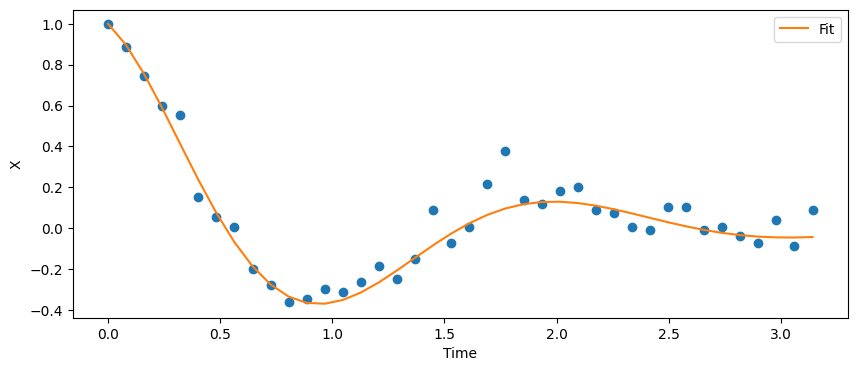

In [4]:
import numpy as np
import matplotlib.pyplot as plt

correct_z = lambda  t, w, a : (np.cos(w * t)) * np.exp(-a * t)
z_p = batch_x.zi_formated[0]

# Plotting
plt.figure(figsize=(10, 4))  # Adjust the figure size to make the plot longer
plt.plot(delay, z_p, 'o')
plt.plot(delay, correct_z(delay, W[0], L[0]), label="Fit")

# Remove axes
# plt.axis('off')
plt.xlabel("Time")
plt.ylabel("X")
plt.legend()
plt.show()
